<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Neural Networks Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>

</div>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Test 20000.cdb to Test 20000.cdb
Saving Train 60000.cdb to Train 60000.cdb


## Loading Dataset

In [ ]:
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result

def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y



In [ ]:
from matplotlib import pyplot as plt
X_train, Y_train = read_hoda_dataset(dataset_path='/content/Train 60000.cdb',
                                images_height=40,
                                images_width=40,
                                one_hot=False,
                                reshape=False)
X_test, Y_test = read_hoda_dataset(dataset_path='/content/Test 20000.cdb',
                              images_height=40,
                              images_width=40,
                              one_hot=False,
                              reshape=False)

<ipython-input-2-91c56dd6c8a4>:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.zeros(shape=[len(labels)], dtype=np.int)


In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 40, 40, 1)
(60000,)
(20000, 40, 40, 1)
(20000,)


## Model Architecture

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import pandas as pd
from sklearn.neural_network import MLPClassifier as mlp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from  skimage import transform
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

model_DCCN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation='relu', input_shape=(40, 40, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3,3), padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(512, (3,3), padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3,3), padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(2, 2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation='softmax'),
] )

model_DCCN.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 40, 40, 64)        640       
                                                                 
 batch_normalization_32 (Bat  (None, 40, 40, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 19, 19, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 19, 19, 64)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 19, 19, 128)       73856     
                                                                 
 batch_normalization_33 (Bat  (None, 19, 19, 128)     

## Train and Test with Adam Optimizer

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1500/1500 [==============================] - 38s 19ms/step - loss: 0.1437 - accuracy: 0.9583 - val_loss: 0.0508 - val_accuracy: 0.9855
Epoch 2/50
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0446 - accuracy: 0.9877 - val_loss: 0.0481 - val_accuracy: 0.9863
Epoch 3/50
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0404 - accuracy: 0.9892 - val_loss: 0.0330 - val_accuracy: 0.9918
Epoch 4/50
1500/1500 [==============================] - 31s 21ms/step - loss: 0.0345 - accuracy: 0.9909 - val_loss: 0.0235 - val_accuracy: 0.9944
Epoch 5/50
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0277 - accuracy: 0.9925 - val_loss: 0.0200 - val_accuracy: 0.9945
Epoch 6/50
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0243 - accuracy: 0.9940 - val_loss: 0.0118 - val_accuracy: 0.9968
Epoch 7/50
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0241 - accuracy: 0.9948 - val_loss: 0.0082 - val_accura

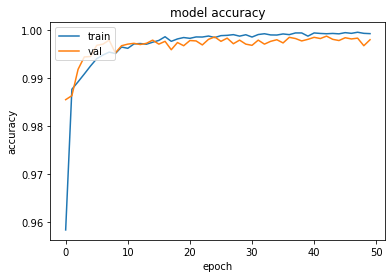

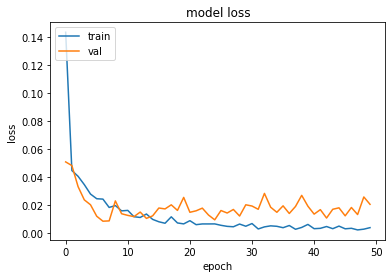

In [ ]:
opt_adam =tf.keras.optimizers.Adam(learning_rate=0.001)
model_DCCN.compile(
    optimizer=opt_adam,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history=model_DCCN.fit(X_train, Y_train , epochs=50, validation_split = 0.2 )
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

625/625 [==============================] - 3s 5ms/step
Confusion Matrix: 
[[1988    0    1    0    2    6    0    3    0    0]
 [   0 1998    1    0    0    0    0    0    0    1]
 [   0    0 1993    2    3    0    0    0    0    2]
 [   0    0   21 1972    4    2    0    0    1    0]
 [   0    0    3    1 1995    0    1    0    0    0]
 [   3    0    0    0    1 1990    0    0    6    0]
 [   0    3    1    0    0    1 1992    0    0    3]
 [   0    1    0    0    0    0    0 1999    0    0]
 [   0    0    0    0    0    0    0    0 2000    0]
 [   0    3    0    0    0    1    3    1    0 1992]]
accuracy:  0.99595
precision:  [0.99849322 0.99650873 0.98663366 0.99848101 0.99501247 0.995
 0.99799599 0.998003   0.99651221 0.996997  ]
recall:  [0.994  0.999  0.9965 0.986  0.9975 0.995  0.996  0.9995 1.     0.996 ]
f1_score:  [0.99624154 0.99775281 0.99154229 0.99220126 0.99625468 0.995
 0.996997   0.99875094 0.99825306 0.99649825]


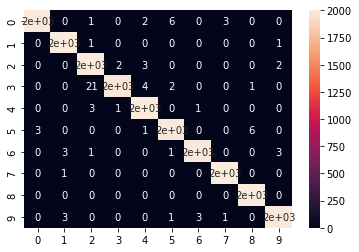

In [ ]:
# predict crisp classes for test set
yhat = model_DCCN.predict(X_test)
y_pred = np.argmax(yhat,axis=1)

#confusion matrix
cf_matrix = confusion_matrix(Y_test, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
print('Confusion Matrix: ')
print(cf_matrix)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, y_pred)
print('accuracy:  %s' % accuracy)
# precision: tp / (tp + fp)
precision = precision_score(Y_test, y_pred,average=None)
print('precision:  %s' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, y_pred,average=None)
print('recall:  %s' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, y_pred,average=None)
print('f1_score:  %s' % f1)

## Train and Test with Adadelta Optimizer

Epoch 1/50
1500/1500 [==============================] - 35s 20ms/step - loss: 1.5735 - accuracy: 0.5251 - val_loss: 1.7857 - val_accuracy: 0.4952
Epoch 2/50
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3956 - accuracy: 0.8654 - val_loss: 0.7500 - val_accuracy: 0.7728
Epoch 3/50
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1700 - accuracy: 0.9448 - val_loss: 0.3738 - val_accuracy: 0.8878
Epoch 4/50
1500/1500 [==============================] - 29s 19ms/step - loss: 0.1128 - accuracy: 0.9658 - val_loss: 0.2348 - val_accuracy: 0.9298
Epoch 5/50
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0821 - accuracy: 0.9747 - val_loss: 0.1389 - val_accuracy: 0.9574
Epoch 6/50
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0687 - accuracy: 0.9790 - val_loss: 0.1330 - val_accuracy: 0.9615
Epoch 7/50
1500/1500 [==============================] - 28s 19ms/step - loss: 0.0561 - accuracy: 0.9831 - val_loss: 0.0932 -

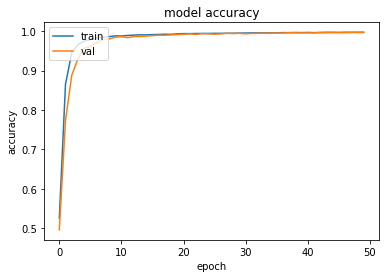

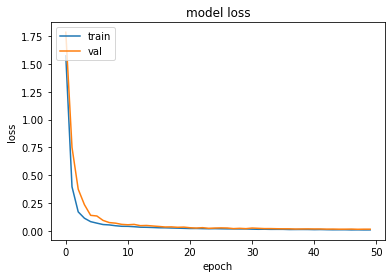

In [ ]:
opt_adadelta =tf.keras.optimizers.Adadelta(learning_rate=0.01)
model_DCCN.compile(
    optimizer=opt_adadelta,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history=model_DCCN.fit(X_train, Y_train , epochs=50, validation_split = 0.2 )
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

625/625 [==============================] - 3s 5ms/step
Confusion Matrix: 
[[1998    0    0    0    1    1    0    0    0    0]
 [   0 2000    0    0    0    0    0    0    0    0]
 [   0    7 1992    0    0    0    0    0    0    1]
 [   0    0   58 1934    7    1    0    0    0    0]
 [   0    0   10    3 1986    0    1    0    0    0]
 [  11    2    3    0    2 1978    0    0    4    0]
 [   0    9    3    0    0    4 1980    0    0    4]
 [   1    7    3    0    0    0    0 1989    0    0]
 [   0    6    0    0    0    0    0    0 1994    0]
 [   1   12    0    0    0    0    2    0    0 1985]]
accuracy:  0.9918
precision:  [0.99353555 0.97895252 0.96278395 0.99845121 0.99498998 0.99697581
 0.99848714 1.         0.997998   0.99748744]
recall:  [0.999  1.     0.996  0.967  0.993  0.989  0.99   0.9945 0.997  0.9925]
f1_score:  [0.99626028 0.98936433 0.97911035 0.98247396 0.99399399 0.99297189
 0.99422546 0.99724242 0.99749875 0.99498747]


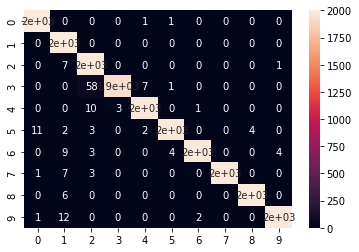

In [ ]:
# predict crisp classes for test set
yhat = model_DCCN.predict(X_test)
y_pred = np.argmax(yhat,axis=1)

#confusion matrix
cf_matrix = confusion_matrix(Y_test, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
print('Confusion Matrix: ')
print(cf_matrix)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, y_pred)
print('accuracy:  %s' % accuracy)
# precision: tp / (tp + fp)
precision = precision_score(Y_test, y_pred,average=None)
print('precision:  %s' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, y_pred,average=None)
print('recall:  %s' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, y_pred,average=None)
print('f1_score:  %s' % f1)

## Train and Test with Momentum Optimizer

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1500/1500 [==============================] - 29s 19ms/step - loss: 0.5300 - accuracy: 0.9367 - val_loss: 0.0578 - val_accuracy: 0.9891
Epoch 2/50
1500/1500 [==============================] - 28s 18ms/step - loss: 0.0771 - accuracy: 0.9842 - val_loss: 0.0288 - val_accuracy: 0.9930
Epoch 3/50
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0457 - accuracy: 0.9895 - val_loss: 0.0206 - val_accuracy: 0.9953
Epoch 4/50
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0337 - accuracy: 0.9918 - val_loss: 0.0203 - val_accuracy: 0.9945
Epoch 5/50
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0278 - accuracy: 0.9931 - val_loss: 0.0162 - val_accuracy: 0.9953
Epoch 6/50
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0222 - accuracy: 0.9943 - val_loss: 0.0146 - val_accuracy: 0.9966
Epoch 7/50
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0187 - accuracy: 0.9954 - val_loss: 0.0154 - val_accura

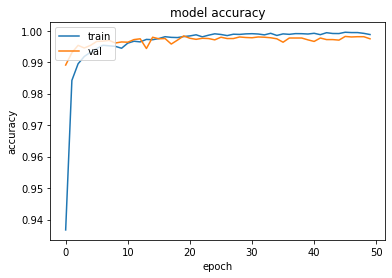

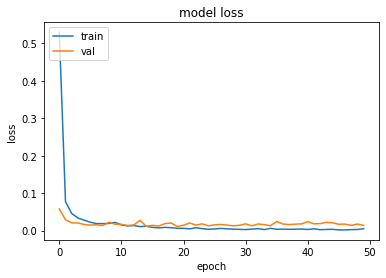

In [ ]:
opt_momentum =tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model_DCCN.compile(
    optimizer=opt_momentum,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history=model_DCCN.fit(X_train, Y_train , epochs=50, validation_split = 0.2 )
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

625/625 [==============================] - 3s 5ms/step
Confusion Matrix: 
[[1997    0    0    0    0    3    0    0    0    0]
 [   1 1997    0    0    0    0    0    0    1    1]
 [   0    1 1989    7    2    0    0    0    0    1]
 [   0    0   16 1980    4    0    0    0    0    0]
 [   0    0    3    9 1986    1    1    0    0    0]
 [   3    0    0    0    1 1993    0    1    2    0]
 [   0    2    2    0    1    2 1989    0    0    4]
 [   0    2    1    0    0    0    0 1997    0    0]
 [   0    0    0    0    0    0    0    0 1999    1]
 [   0    6    0    0    1    1    3    0    2 1987]]
accuracy:  0.9957
precision:  [0.998001   0.99452191 0.98906017 0.99198397 0.99548872 0.9965
 0.99799298 0.9994995  0.99750499 0.99648947]
recall:  [0.9985 0.9985 0.9945 0.99   0.993  0.9965 0.9945 0.9985 0.9995 0.9935]
f1_score:  [0.99825044 0.99650699 0.99177263 0.99099099 0.9942428  0.9965
 0.99624343 0.9989995  0.9985015  0.99499249]


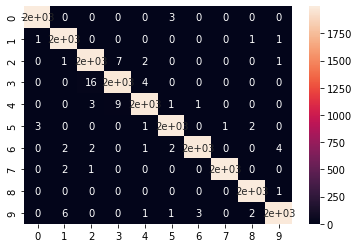

In [ ]:
# predict crisp classes for test set
yhat = model_DCCN.predict(X_test)
y_pred = np.argmax(yhat,axis=1)

#confusion matrix
cf_matrix = confusion_matrix(Y_test, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
print('Confusion Matrix: ')
print(cf_matrix)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, y_pred)
print('accuracy:  %s' % accuracy)
# precision: tp / (tp + fp)
precision = precision_score(Y_test, y_pred,average=None)
print('precision:  %s' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, y_pred,average=None)
print('recall:  %s' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, y_pred,average=None)
print('f1_score:  %s' % f1)